# Week 2 - Word embeddings

## Working with IMDB reviews dataset

http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.2.0


### Loading the dataset

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHLSHXH/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHLSHXH/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHLSHXH/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

print(training_sentences[0])
print(training_labels_final[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0


### Tokenizing the sentences

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Let's build a function that will return us the sentence from a tokenized sequence:

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received '
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'


### Building a model

We'll have an `Embedding` layer which will learn a representation of the words in the corpus based on their relation with the corpus labels.

#### Sequential model with `Flatten`

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim, 
                              input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


We can see that the embedding layer has 16000 params: we have 10000 words in the vocabulary, and each one will be represented in a 16 length vector.

After flattening, the shape is 1920 because we have a maximum length of 120 and 16 length vectors for each word of those 120.

In [7]:
num_epochs = 10
model.fit(padded,
          training_labels_final, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 7ms/step - loss: 0.5019 - accuracy: 0.7333 - val_loss: 0.3475 - val_accuracy: 0.8473
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2437 - accuracy: 0.9050 - val_loss: 0.3740 - val_accuracy: 0.8368
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0946 - accuracy: 0.9751 - val_loss: 0.4459 - val_accuracy: 0.8271
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0237 - accuracy: 0.9967 - val_loss: 0.5283 - val_accuracy: 0.8250
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0060 - accuracy: 0.9996 - val_loss: 0.5943 - val_accuracy: 0.8232
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6396 - val_accuracy: 0.8263
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 8.7990e-04 - accuracy: 1.0000 - val_loss: 0.6842 - val_accuracy: 0.8265
Ep

In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


#### Sequential model with average pooling

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim, 
                              input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 10
model.fit(padded,
          training_labels_final, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 7ms/step - loss: 0.5490 - accuracy: 0.7591 - val_loss: 0.3876 - val_accuracy: 0.8414
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.3347 - accuracy: 0.8610 - val_loss: 0.3312 - val_accuracy: 0.8584
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2718 - accuracy: 0.8905 - val_loss: 0.3308 - val_accuracy: 0.8582
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2345 - accuracy: 0.9090 - val_loss: 0.3479 - val_accuracy: 0.8515
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2095 - accuracy: 0.9215 - val_loss: 0.3672 - val_accuracy: 0.8465
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1882 - accuracy: 0.9326 - val_loss: 0.3920 - val_accuracy: 0.8408
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1708 - accuracy: 0.9388 - val_loss: 0.4197 - val_accuracy: 0.8378
Epoch 

As opposed to using `Flatten`, now each text is represented by a unique 16 length vector, which is the average of the word vectors in the text.

After training we can see that the performance is a bit worse.

### Visualizing the embeddings

We'll write them in two files:

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

And download them:

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

Now, we can go to `projector.tensorflow.org` and load those files to see how it looks.

## Working with the sarcasm dataset

In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Let's define some hyperparameters:

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

And get the dataset:

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-05-30 19:19:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  20.9MB/s    in 0.3s    

2020-05-30 19:19:01 (20.9 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

Tokenize the sentences:

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

And train the model:

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6634 - accuracy: 0.5810 - val_loss: 0.5764 - val_accuracy: 0.7515
Epoch 2/30
625/625 - 3s - loss: 0.4330 - accuracy: 0.8310 - val_loss: 0.3927 - val_accuracy: 0.8278
Epoch 3/30
625/625 - 3s - loss: 0.3123 - accuracy: 0.8764 - val_loss: 0.3534 - val_accuracy: 0.8526
Epoch 4/30
625/625 - 3s - loss: 0.2597 - accuracy: 0.9010 - val_loss: 0.3445 - val_accuracy: 0.8575
Epoch 5/30
625/625 - 3s - loss: 0.2228 - accuracy: 0.9148 - val_loss: 0.3452 - val_accuracy: 0.8553
Epoch 6/30
625/625 - 3s - loss: 0.1976 - accuracy: 0.9255 - val_loss: 0.3538 - val_accuracy: 0.8518
Epoch 7/30
625/625 - 3s - loss: 0.1730 - accuracy: 0.9358 - val_loss: 0.3642 - val_accuracy: 0.8542
Epoch 8/30
625/625 - 3s - loss: 0.1547 - accuracy: 0.9427 - val_loss: 0.3916 - val_accuracy: 0.8465
Epoch 9/30
625/625 - 3s - loss: 0.1394 - accuracy: 0.9489 - val_loss: 0.3993 - val_accuracy: 0.8518
Epoch 10/30
625/625 - 3s - loss: 0.1260 - accuracy: 0.9553 - val_loss: 0.4288 - val_accuracy: 0.8456

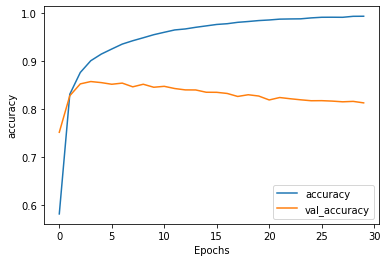

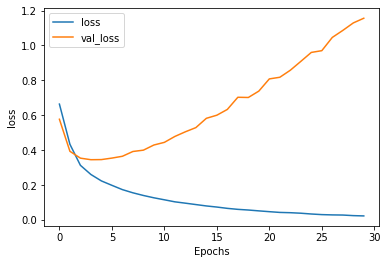

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We have a strong overfitting. It is important to know that, apart from the usual neural network parameter tuning, also tuning the vocabulary parameters will lead to important changes in the model performance.

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

And visualize the word embeddings:

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

Let's make some predictions:

In [24]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.1936409e-01]
 [8.7615456e-07]]


## Pre-tokenized datasets and sub-word tokenization

We can find some pre-tokenized datasets here:

* https://www.tensorflow.org/datasets/catalog/overview
* https://github.com/tensorflow/datasets/tree/master/docs/catalog

We'll use them to explore the options we have when tokenizing based on **sub-words**.

https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

In [0]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [42]:
train_data, test_data = imdb['train'], imdb['test']

tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

Sub-word tokenization:

In [47]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [29]:
for ts in tokenized_string:
  print('{} -> {}'.format(ts, tokenizer.decode([ts])))

6307 -> Ten
2327 -> sor
4043 -> Fl
2120 -> ow
2 -> , 
48 -> from 
4249 -> basi
4429 -> cs 
7 -> to 
2652 -> master
8050 -> y


We can see that it is case sensitive, differently from the normal Tokenizer.

In [35]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32,train_data.output_shapes))

In [50]:
num_epochs = 10

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    epochs=num_epochs, 
                    validation_data=test_batches)

Epoch 1/10
782/782 [==============================] - 16s 20ms/step - loss: 0.6200 - accuracy: 0.6824 - val_loss: 0.4833 - val_accuracy: 0.8288
Epoch 2/10
782/782 [==============================] - 16s 20ms/step - loss: 0.3723 - accuracy: 0.8685 - val_loss: 0.3553 - val_accuracy: 0.8550
Epoch 3/10
782/782 [==============================] - 16s 20ms/step - loss: 0.2775 - accuracy: 0.8991 - val_loss: 0.3134 - val_accuracy: 0.8785
Epoch 4/10
782/782 [==============================] - 16s 20ms/step - loss: 0.2352 - accuracy: 0.9164 - val_loss: 0.3062 - val_accuracy: 0.8802
Epoch 5/10
782/782 [==============================] - 15s 20ms/step - loss: 0.2095 - accuracy: 0.9249 - val_loss: 0.3067 - val_accuracy: 0.8817
Epoch 6/10
782/782 [==============================] - 15s 20ms/step - loss: 0.1889 - accuracy: 0.9332 - val_loss: 0.3111 - val_accuracy: 0.8815
Epoch 7/10
782/782 [==============================] - 15s 20ms/step - loss: 0.1729 - accuracy: 0.9396 - val_loss: 0.3288 - val_accuracy:

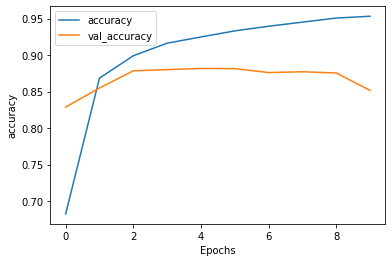

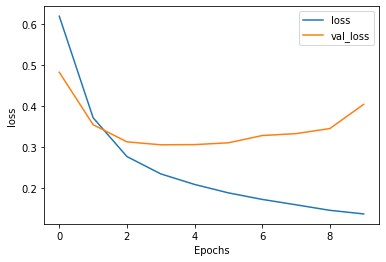

In [51]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

However, this sub-words approach makes no sense if the order of the sequences is not maintained. We'll see how to do it in the next week.